# Spam Detection in SMS (text) data By BERT
https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8

In [1]:
!pip install wordcloud

In [2]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

2023-12-10 10:53:38.366325: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 10:53:38.402786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 10:53:38.402829: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 10:53:38.402854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 10:53:38.409399: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 10:53:38.410274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

#### Load and explore the spam data


In [3]:
url = './sms_spam_collection/SMSSpamCollection.txt'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:5]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [6]:
messages.groupby('label').describe().T


label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [7]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

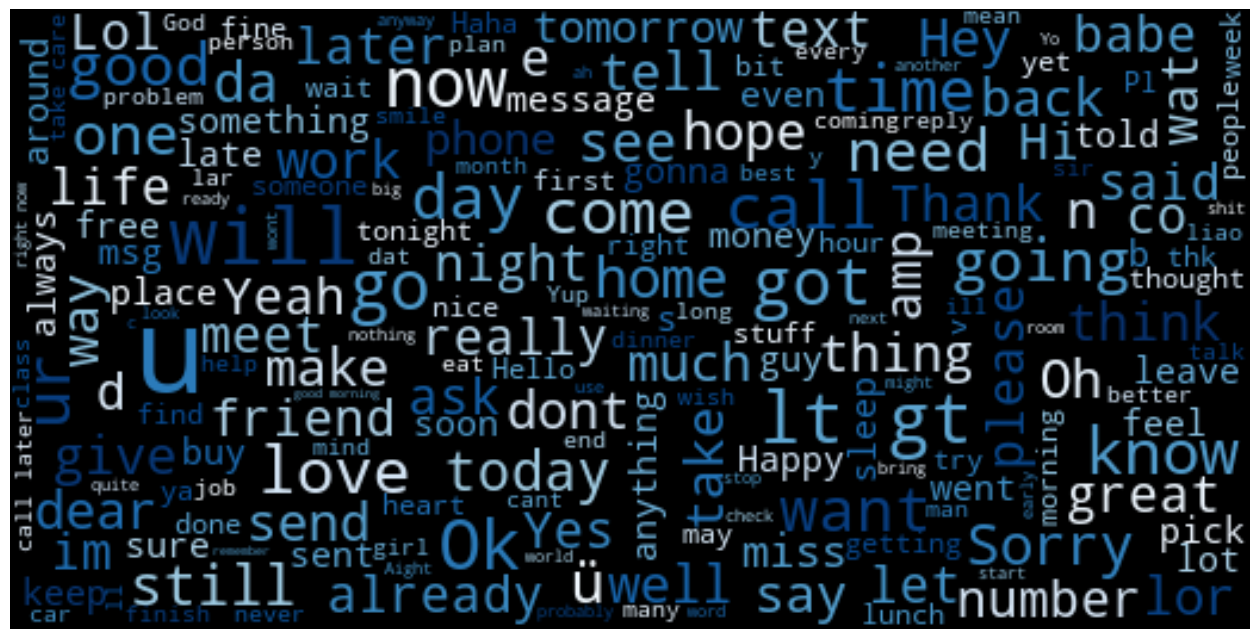

In [8]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

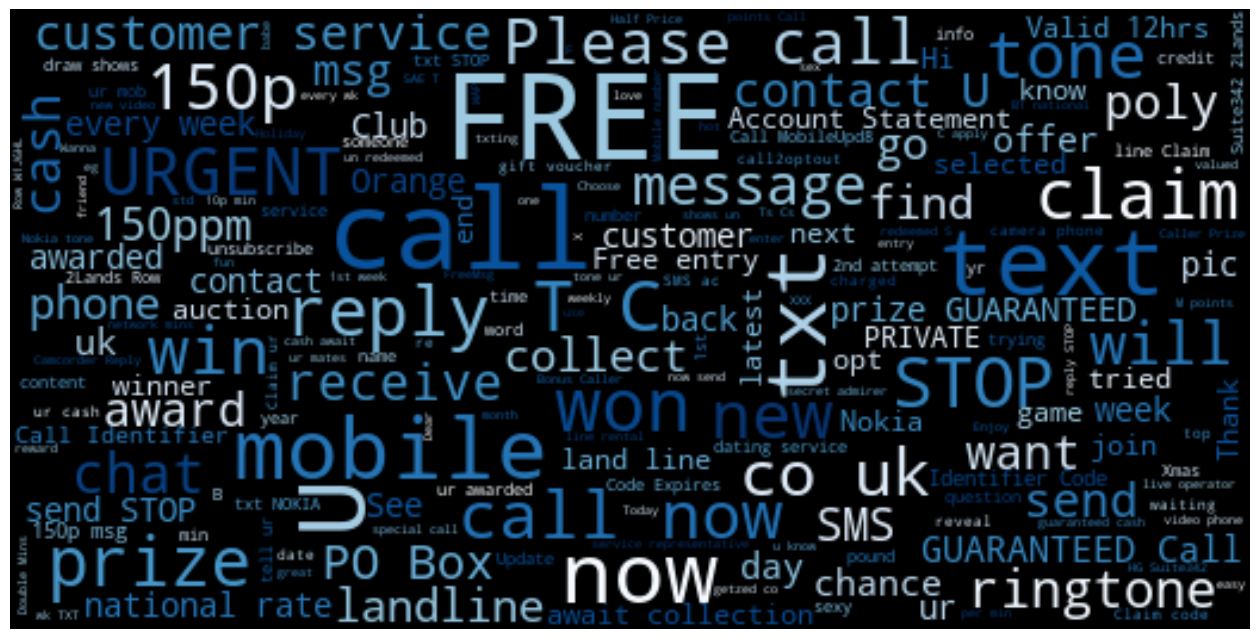

In [9]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

15.481865284974095

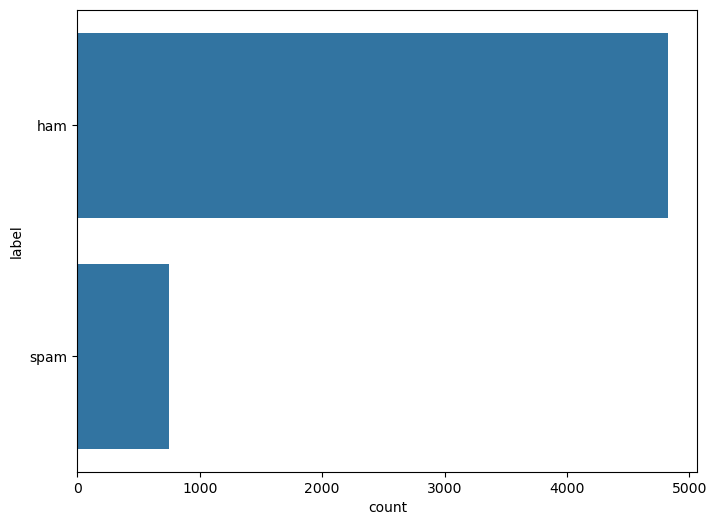

In [10]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 

In [11]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)


(747, 2) (747, 2)


Text(0, 0.5, 'Message types')

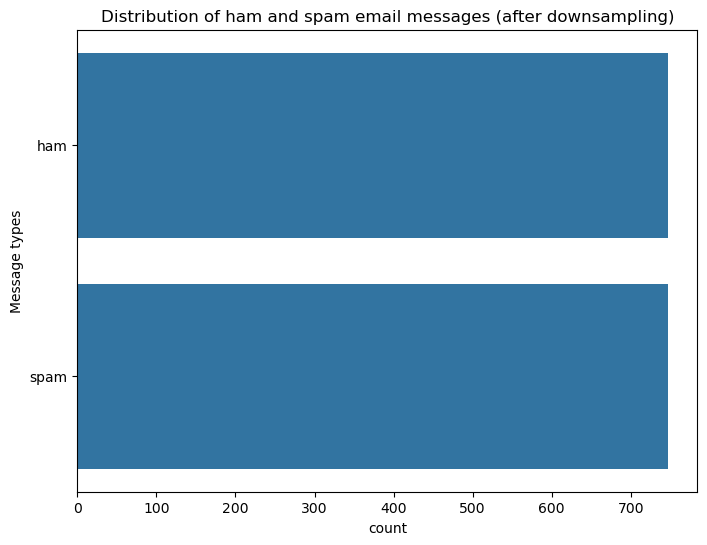

In [12]:
# Create a dataframe with these ham and spam msg
frames = [ham_msg_df, spam_msg_df]
msg_df = pd.concat(frames)
msg_df.reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.ylabel('Message types')

In [13]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
msg_df

,label,message,text_length
3234,ham,Height of recycling: Read twice- People spend ...,149
3804,ham,Yup song bro. No creative. Neva test quality. ...,74
2701,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to...",165
2820,ham,Don't forget who owns you and who's private pr...,111
5161,ham,Lol no. I just need to cash in my nitros. Hurr...,75
...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,158
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,160
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147


In [14]:
#Calculate average length by label types
msg_df_group = msg_df.drop(['message'], axis=1)
labels_df = msg_df_group.groupby('label').mean()
labels_df

,text_length
label,
ham,73.238286
spam,138.670683


In [15]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [16]:
msg_df

,label,message,text_length,msg_type
3234,ham,Height of recycling: Read twice- People spend ...,149,0
3804,ham,Yup song bro. No creative. Neva test quality. ...,74,0
2701,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to...",165,0
2820,ham,Don't forget who owns you and who's private pr...,111,0
5161,ham,Lol no. I just need to cash in my nitros. Hurr...,75,0
...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90,1
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,158,1
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,160,1
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147,1


In [17]:
msg_label

array([0, 0, 0, ..., 1, 1, 1])

#### Prepare train/test data and pre-process text


In [18]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

#### Tokenization
convert text into numerical representation of text

##### Hyper-parameters used in Tokenizer object are: num_words and oov_token, char_level.

num_words: Indicate how many unique words to load in training and testing data. For our purpose, we selected 500 words (vocab_size)
oov_token: When its used, out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls (see below).
char_level: If it is “True” then every character will be treated as a token. We set it as “False”, hence every word will be treated as a token.


In [19]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [20]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [26]:
# Get the word_index 
word_index = tokenizer.word_index
# word_index 
# {'<OOV>': 1,
#  'to': 2,
#  'you': 3,
#  'a': 4,
#  'i': 5,
#  'call': 6,
#  'the': 7,
#  'u': 8,
#  'your': 9,
#  'for': 10,
#  'is': 11,
#  '2': 12,
#  'and': 13,
#  'now': 14,

In [28]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


#### Sequencing and Padding

padding = ‘pre’ or ‘post (default pre). By using pre, we pad before each sequence and by using post we pad after each sequence.

maxlen = maximum length of all sequences. Here max_len=50 hence, we are only going to use 50 words in a sentence. If not provided, by default it will use the maximum length of the longest sentence.

truncating = ‘pre’ or ‘post’ (default ‘pre’). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. ‘pre’ option will truncate at the beginning where as ‘post’ will truncate at the end of the sequences.

In [29]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [31]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)


Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [32]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [33]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [34]:
print(training_padded[0])


[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


#### Spam Detection Model
